# Lesson 1 - ISIC_2019 dataset

The "ISIC 2019: Training" data includes content from several copyright holders. To comply with the attribution requirements of the CC-BY-NC license, the aggregate "ISIC 2019: Training" data must be cited as:

ISIC 2019 data is provided courtesy of the following sources:
BCN_20000 Dataset: (c) Department of Dermatology, Hospital Clínic de Barcelona
HAM10000 Dataset: (c) by ViDIR Group, Department of Dermatology, Medical University of Vienna; https://doi.org/10.1038/sdata.2018.161
MSK Dataset: (c) Anonymous; https://arxiv.org/abs/1710.05006 ; https://arxiv.org/abs/1902.03368

When referencing this dataset in your own manuscripts and publications, please use the following full citations:

[1] Tschandl P., Rosendahl C. & Kittler H. The HAM10000 dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. Sci. Data 5, 180161 doi.10.1038/sdata.2018.161 (2018)

[2] Noel C. F. Codella, David Gutman, M. Emre Celebi, Brian Helba, Michael A. Marchetti, Stephen W. Dusza, Aadi Kalloo, Konstantinos Liopyris, Nabin Mishra, Harald Kittler, Allan Halpern: “Skin Lesion Analysis Toward Melanoma Detection: A Challenge at the 2017 International Symposium on Biomedical Imaging (ISBI), Hosted by the International Skin Imaging Collaboration (ISIC)”, 2017; arXiv:1710.05006.

# Data Provenance
# BCN_20000
Dermatoscopic images of the most common classes of skin lesions: Actinic Keratosis, Squamous Cell Carcinoma, Basal Cell Carcinoma, Seborrheic Keratosis, Solar Lentigo, Dermatofibroma, Nevi, Melanoma, and Vascular Lesions. Images are made available from the Department of Dermatology of the Hospital Clínic de Barcelona for the preparation of the ISIC Challenge 2019.

# HAM10000
https://www.nature.com/articles/sdata2018161

# MSK
https://arxiv.org/abs/1710.05006



Using fast.ai lesson 1 again for detecting cancer!  Check out https://course.fast.ai/ for the low down on this. 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate


If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [3]:
bs = 64
origimagesize = 1024
firstpasssize = origimagesize // 10
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Download the data

`!mkdir datasets
!cd datasets/
!wget https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Training_Input.zip
!wget https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Training_Metadata.csv
!wget https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Training_GroundTruth.csv
!mkdir ISIC_2019_Training_Input
!unzip -qu ISIC_2019_Training_Input.zip -d ISIC_2019_Training_Input
!rm ISIC_2019_Training_Input.zip
`

TODO show how to convert the ISIC_2019_Training_GroundTruth.csv to usable format for fast.ai

In [4]:
path_train = Path('/home/jupyter/datasets/ISIC_2019_Training_Input')
path = Path('/home/jupyter/datasets')

fnames = get_image_files(path_train)
fnames[:5]

[PosixPath('/home/jupyter/datasets/ISIC_2019_Training_Input/ISIC_0032922.jpg'),
 PosixPath('/home/jupyter/datasets/ISIC_2019_Training_Input/ISIC_0028680.jpg'),
 PosixPath('/home/jupyter/datasets/ISIC_2019_Training_Input/ISIC_0024993.jpg'),
 PosixPath('/home/jupyter/datasets/ISIC_2019_Training_Input/ISIC_0025534.jpg'),
 PosixPath('/home/jupyter/datasets/ISIC_2019_Training_Input/ISIC_0033810.jpg')]

In [5]:
np.random.seed(2)
label_path = Path('/home/jupyter/datasets/ISIC_2019_Training_GroundTruth-mod2.csv')
df = pd.read_csv(label_path)
df.head()

,image,category
0,ISIC_2019_Training_Input/ISIC_0000000.jpg,NV
1,ISIC_2019_Training_Input/ISIC_0000001.jpg,NV
2,ISIC_2019_Training_Input/ISIC_0000002.jpg,MEL
3,ISIC_2019_Training_Input/ISIC_0000003.jpg,NV
4,ISIC_2019_Training_Input/ISIC_0000004.jpg,MEL


In [6]:
# Categories of the diferent diseases
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

If running the larger image size - after restarting the VM - run up to here.

In [9]:
data = ImageDataBunch.from_csv(path, csv_labels='ISIC_2019_Training_GroundTruth-mod2.csv', 
                               ds_tfms=get_transforms(), 
                               size=firstpasssize).normalize(imagenet_stats)
#.split_by_rand_pct(valid_pct=0.2, seed=34)

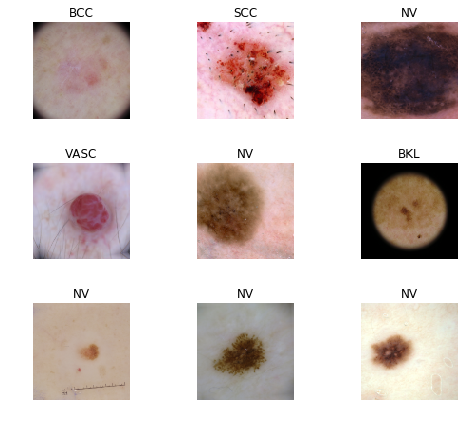

In [10]:
data.show_batch(rows=3, figsize=(7,6))

In [11]:
print(data.classes)
len(data.classes),data.c

['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']


(8, 8)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [12]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [13]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [14]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.136771,0.999689,0.359455,03:44
1,0.991183,0.913221,0.335965,02:49
2,0.924242,0.855893,0.313265,02:49
3,0.864081,0.842892,0.311094,02:47


In [15]:
learn.save('ISIC2019-stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [16]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

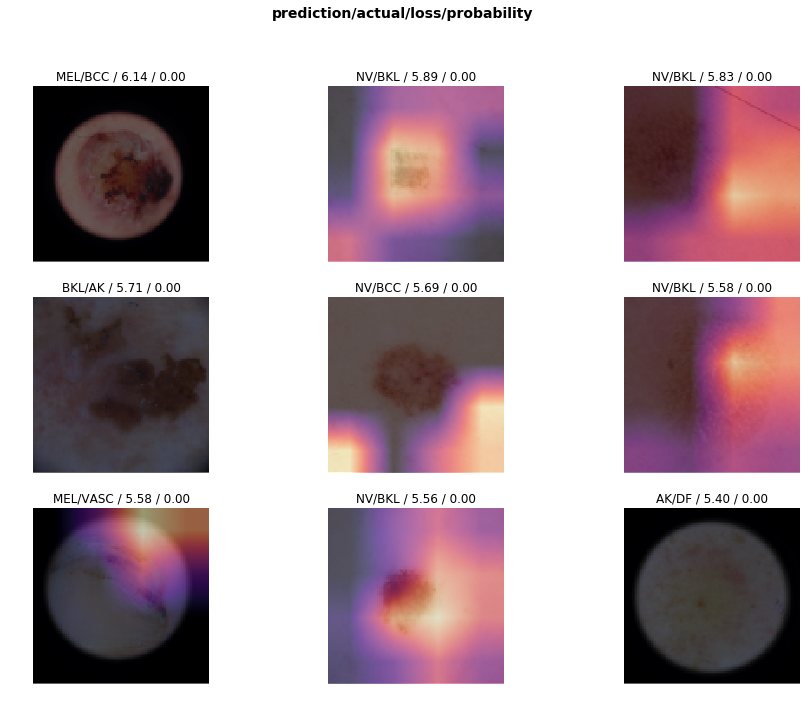

In [17]:
interp.plot_top_losses(9, figsize=(15,11))

In [18]:
doc(interp.plot_top_losses)

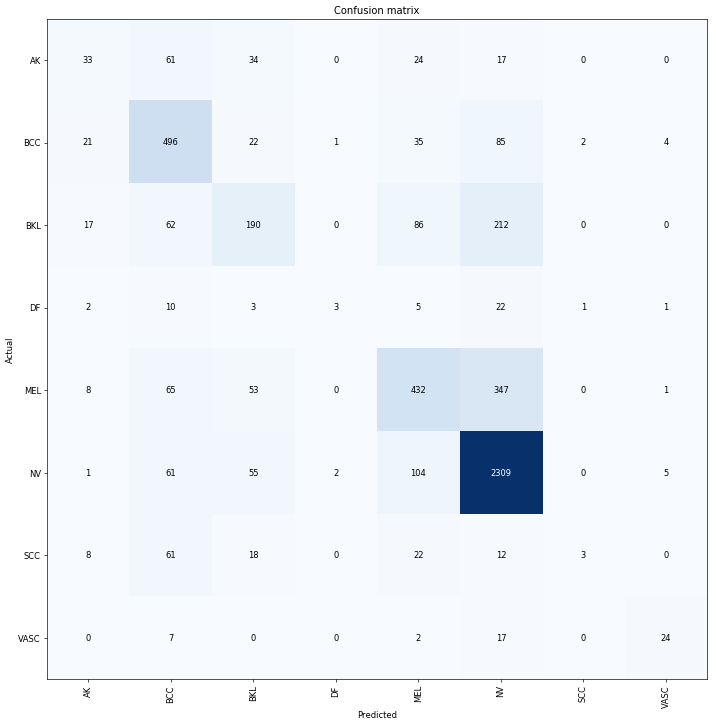

In [19]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [20]:
interp.most_confused(min_val=2)

[('MEL', 'NV', 347),
 ('BKL', 'NV', 212),
 ('NV', 'MEL', 104),
 ('BKL', 'MEL', 86),
 ('BCC', 'NV', 85),
 ('MEL', 'BCC', 65),
 ('BKL', 'BCC', 62),
 ('AK', 'BCC', 61),
 ('NV', 'BCC', 61),
 ('SCC', 'BCC', 61),
 ('NV', 'BKL', 55),
 ('MEL', 'BKL', 53),
 ('BCC', 'MEL', 35),
 ('AK', 'BKL', 34),
 ('AK', 'MEL', 24),
 ('BCC', 'BKL', 22),
 ('DF', 'NV', 22),
 ('SCC', 'MEL', 22),
 ('BCC', 'AK', 21),
 ('SCC', 'BKL', 18),
 ('AK', 'NV', 17),
 ('BKL', 'AK', 17),
 ('VASC', 'NV', 17),
 ('SCC', 'NV', 12),
 ('DF', 'BCC', 10),
 ('MEL', 'AK', 8),
 ('SCC', 'AK', 8),
 ('VASC', 'BCC', 7),
 ('DF', 'MEL', 5),
 ('NV', 'VASC', 5),
 ('BCC', 'VASC', 4),
 ('DF', 'BKL', 3),
 ('BCC', 'SCC', 2),
 ('DF', 'AK', 2),
 ('NV', 'DF', 2),
 ('VASC', 'MEL', 2)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [21]:
learn.unfreeze()

In [22]:
learn.load('ISIC2019-stage-1');

In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


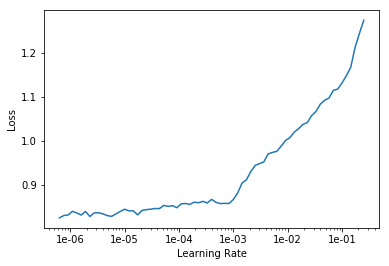

In [24]:
learn.recorder.plot()

In [25]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.853435,0.810670,0.298263,02:50
1,0.826472,0.801900,0.293328,02:50


In [28]:
learn.save('ISIC2019-stage-2')

That's a pretty accurate model!

Now try at bigger size

In [7]:
from fastai.utils.mem import *
size = origimagesize

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=1, have 7601MB of GPU RAM free


In [8]:
currentsize = origimagesize // 4 

In [9]:
data = ImageDataBunch.from_csv(path, csv_labels='ISIC_2019_Training_GroundTruth-mod2.csv', 
                               ds_tfms=get_transforms(), 
                               size=currentsize).normalize(imagenet_stats)

In [10]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [16]:
learn.load('ISIC2019-stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (20265 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
NV,MEL,MEL,NV,NV
Path: /home/jupyter/datasets;

Valid: LabelList (5066 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
NV,BCC,MEL,BKL,NV
Path: /home/jupyter/datasets;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [18]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.840759,0.720033,0.269641,03:57
1,0.806432,0.683569,0.255626,03:54
2,0.735226,0.646661,0.243585,03:53
3,0.702760,0.637623,0.240624,03:53


In [19]:
learn.save('ISIC2019-stage-3-25percentsize')

In [11]:
learn.load('ISIC2019-stage-3-25percentsize')

Learner(data=ImageDataBunch;

Train: LabelList (20265 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
NV,NV,MEL,NV,MEL
Path: /home/jupyter/datasets;

Valid: LabelList (5066 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
NV,BKL,NV,NV,NV
Path: /home/jupyter/datasets;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [12]:
learn.unfreeze()

In [13]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


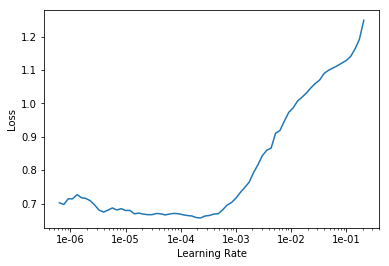

In [14]:
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(4, max_lr=slice(1e-4,5e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.771450,0.739699,0.271812,04:36
1,0.705136,0.629085,0.235689,03:54
2,0.522794,0.527176,0.192065,03:55
3,0.371489,0.467660,0.172325,03:56


In [16]:
learn.save('ISIC2019-stage-4-25percentsize')

In [17]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


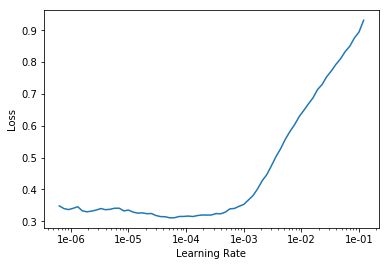

In [18]:
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(4, max_lr=slice(1e-4,5e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.491691,0.633923,0.227596,03:54
1,0.518199,0.553369,0.204501,03:57
2,0.344649,0.463403,0.163837,03:59
3,0.220876,0.427111,0.150415,04:00


In [20]:
learn.save('ISIC2019-stage-4.2-25percentsize')

In [21]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

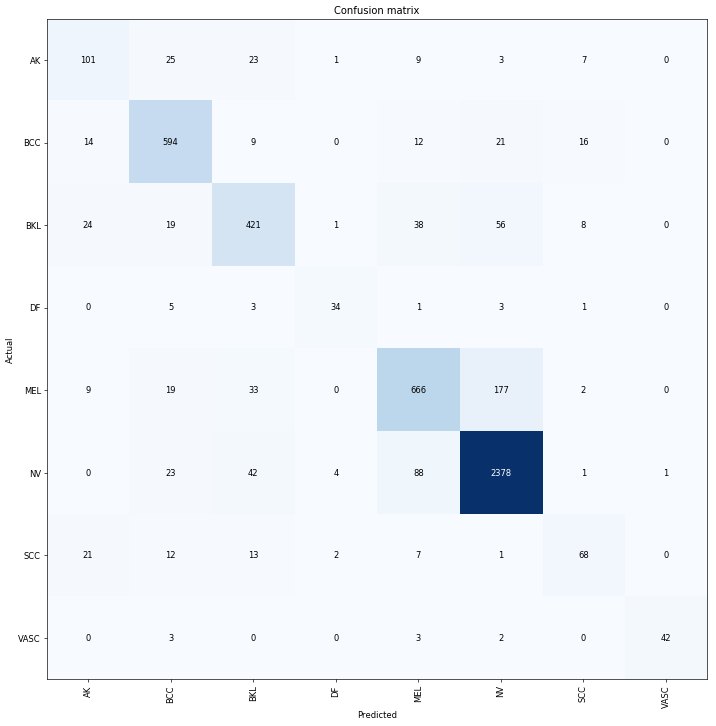

In [22]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [23]:
interp.most_confused(min_val=10)

[('MEL', 'NV', 177),
 ('NV', 'MEL', 88),
 ('BKL', 'NV', 56),
 ('NV', 'BKL', 42),
 ('BKL', 'MEL', 38),
 ('MEL', 'BKL', 33),
 ('AK', 'BCC', 25),
 ('BKL', 'AK', 24),
 ('AK', 'BKL', 23),
 ('NV', 'BCC', 23),
 ('BCC', 'NV', 21),
 ('SCC', 'AK', 21),
 ('BKL', 'BCC', 19),
 ('MEL', 'BCC', 19),
 ('BCC', 'SCC', 16),
 ('BCC', 'AK', 14),
 ('SCC', 'BKL', 13),
 ('BCC', 'MEL', 12),
 ('SCC', 'BCC', 12)]

Trying restarting again with 25% images and seeing if further training reduces error

In [7]:
currentsize = origimagesize // 4 
data = ImageDataBunch.from_csv(path, csv_labels='ISIC_2019_Training_GroundTruth-mod2.csv', 
                               ds_tfms=get_transforms(), 
                               size=currentsize).normalize(imagenet_stats)
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.load('ISIC2019-stage-4.2-25percentsize')

Learner(data=ImageDataBunch;

Train: LabelList (20265 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
NV,NV,MEL,NV,MEL
Path: /home/jupyter/datasets;

Valid: LabelList (5066 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
NV,BKL,NV,NV,NV
Path: /home/jupyter/datasets;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [9]:
learn.unfreeze()

In [10]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


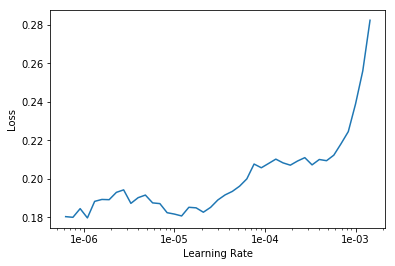

In [11]:
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(10, max_lr=slice(5e-6,1e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.150524,0.423348,0.142914,04:09
1,0.151593,0.422207,0.142914,04:08
2,0.149929,0.426649,0.144295,04:09
3,0.140220,0.428143,0.139755,04:07
4,0.141065,0.427656,0.139558,04:10
5,0.115068,0.428062,0.138768,04:09
6,0.124593,0.434439,0.137979,04:07
7,0.112939,0.435476,0.139558,04:07
8,0.110182,0.433689,0.138176,04:07
9,0.109836,0.434505,0.136597,04:09


In [15]:
learn.save('ISIC2019-stage-4.2-25percentsize')

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [16]:
currentsize = 229
data = ImageDataBunch.from_csv(path, csv_labels='ISIC_2019_Training_GroundTruth-mod2.csv', 
                               ds_tfms=get_transforms(), 
                               size=currentsize).normalize(imagenet_stats)


In [17]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


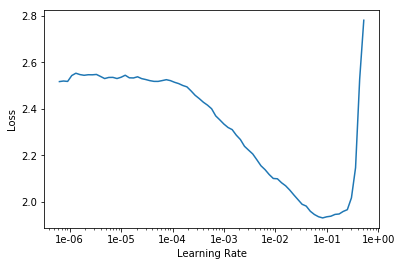

In [18]:
learn.lr_find()
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,1.131853,0.901277,0.317015,04:19
1,0.923487,0.788199,0.285038,04:16
2,0.845697,0.760298,0.280497,04:16
3,0.746552,0.683524,0.251480,04:16
4,0.675584,0.641437,0.233912,04:16
5,0.630715,0.605568,0.220490,04:15
6,0.582476,0.588776,0.216542,04:15
7,0.559682,0.583829,0.215160,04:15


In [20]:
learn.save('ISIC2019-stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [21]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.592249,0.575774,0.212989,05:24
1,0.542655,0.552721,0.205882,05:21
2,0.491329,0.545588,0.201934,05:21


If it doesn't, you can always go back to your previous model.

In [23]:
learn.save('ISIC2019-stage-2-50');

In [24]:
interp = ClassificationInterpretation.from_learner(learn)

In [25]:
interp.most_confused(min_val=2)

[('MEL', 'NV', 268),
 ('NV', 'MEL', 94),
 ('BKL', 'NV', 84),
 ('BKL', 'MEL', 53),
 ('NV', 'BKL', 47),
 ('AK', 'BCC', 46),
 ('BCC', 'NV', 42),
 ('SCC', 'BCC', 39),
 ('MEL', 'BCC', 31),
 ('NV', 'BCC', 31),
 ('MEL', 'BKL', 30),
 ('AK', 'BKL', 28),
 ('BKL', 'BCC', 24),
 ('BKL', 'AK', 21),
 ('BCC', 'MEL', 15),
 ('BCC', 'AK', 13),
 ('SCC', 'AK', 13),
 ('BCC', 'SCC', 12),
 ('BCC', 'BKL', 11),
 ('DF', 'BCC', 10),
 ('SCC', 'BKL', 10),
 ('MEL', 'AK', 9),
 ('DF', 'NV', 7),
 ('SCC', 'NV', 7),
 ('AK', 'MEL', 6),
 ('AK', 'SCC', 6),
 ('DF', 'BKL', 6),
 ('MEL', 'DF', 6),
 ('MEL', 'SCC', 6),
 ('VASC', 'NV', 6),
 ('SCC', 'MEL', 5),
 ('BKL', 'SCC', 4),
 ('NV', 'AK', 4),
 ('SCC', 'DF', 4),
 ('DF', 'AK', 3),
 ('DF', 'SCC', 3),
 ('NV', 'SCC', 3),
 ('AK', 'DF', 2),
 ('AK', 'NV', 2),
 ('NV', 'DF', 2),
 ('VASC', 'BCC', 2)]

In [26]:
learn.fit_one_cycle(6, max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.484576,0.544607,0.199171,05:20
1,0.489699,0.536162,0.198974,05:21
2,0.481590,0.533980,0.196802,05:25
3,0.449089,0.525554,0.197197,05:23
4,0.453587,0.528482,0.194433,05:22
5,0.440720,0.524320,0.192657,05:22


In [27]:
learn.save('ISIC2019-stage-2.5-50');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


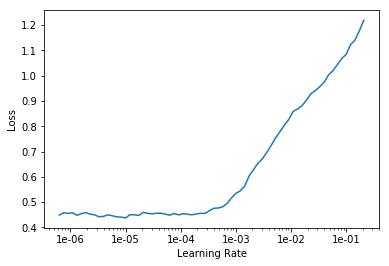

In [28]:
learn.lr_find()
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(10, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.448741,0.522967,0.192065,05:22
1,0.464176,0.524379,0.191275,05:22
2,0.451116,0.520850,0.191473,05:21
3,0.397883,0.491257,0.180221,05:21
4,0.334354,0.463706,0.170549,05:22
5,0.262122,0.444967,0.152388,05:21
6,0.210786,0.439922,0.148835,05:22
7,0.165531,0.434394,0.143506,05:21
8,0.148095,0.434742,0.142124,05:23
9,0.132374,0.437341,0.142519,05:21


13.6 to beat resnet34

In [35]:
learn.save('ISIC2019-stage-2.5-50');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


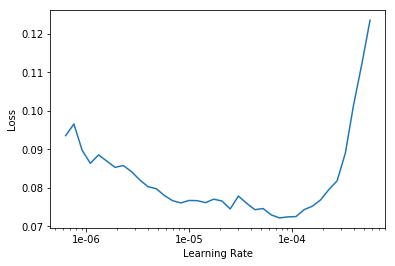

In [34]:
learn.lr_find()
learn.recorder.plot()

In [36]:
learn.fit_one_cycle(6, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.090053,0.479615,0.143111,05:22
1,0.131387,0.549972,0.157323,05:23
2,0.116273,0.513231,0.147454,05:22
3,0.088988,0.499428,0.141532,05:22
4,0.063923,0.469054,0.130280,05:22
5,0.048686,0.466253,0.131465,05:20


In [37]:
learn.save('ISIC2019-stage-2.5-50')

Try with double size image resolution

In [38]:
currentsize = 229 * 2
data = ImageDataBunch.from_csv(path, csv_labels='ISIC_2019_Training_GroundTruth-mod2.csv', 
                               ds_tfms=get_transforms(), 
                               size=currentsize).normalize(imagenet_stats)

As messing with input layer, need to unfreeze

In [39]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


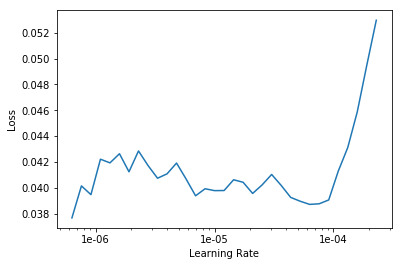

In [40]:
learn.lr_find()
learn.recorder.plot()

In [41]:
learn.fit_one_cycle(6, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.051544,0.502639,0.134426,05:21
1,0.106297,0.573130,0.151599,05:22
2,0.092454,0.580232,0.154560,05:22
3,0.067920,0.534954,0.136794,05:22
4,0.048101,0.501023,0.123371,05:21
5,0.033246,0.494500,0.122977,05:21


In [43]:
learn.save('ISIC2019-stage-2.5-50-bigimage')

In [44]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


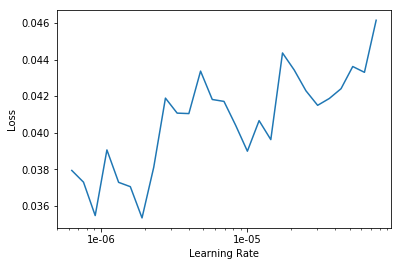

In [46]:
learn.lr_find()
learn.recorder.plot()

In [48]:
learn.fit_one_cycle(6, max_lr=slice(1e-6,3e-6))

epoch,train_loss,valid_loss,error_rate,time
0,0.029395,0.501250,0.122977,05:21
1,0.029552,0.493744,0.124161,05:22
2,0.027236,0.494287,0.121792,05:21
3,0.024310,0.493550,0.121990,05:21
4,0.020402,0.489320,0.121003,05:22
5,0.020946,0.489699,0.120805,05:21


In [49]:
learn.save('ISIC2019-stage-2.5-50-bigimage')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


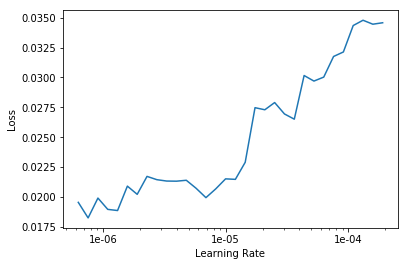

In [50]:
learn.lr_find()
learn.recorder.plot()

Giving up as learning below 1e-6 is sloooooow